## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [4]:
#Импорьтируем необходимые для работы библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy as sp
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [5]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


- *user_id* - идентификатор пользователя, зашедшего на сайт
- *date* -	дата захода
- *group*	- группа теста (контрольная — А или тестовая — B)
- *purchase* -	признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет)
- *price*	- цена купленного тура (если покупка не состоялась, цена равна 0)

## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [7]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

data.groupby('group')['date'].agg(['min','max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [8]:
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [9]:
group_data = data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count', 'purchase': 'sum_purchase', 'price': 'sum_price'})
group_data.head()

,group,users_count,sum_purchase,sum_price
0,A,147202,17723,1436260000
1,B,147276,17514,1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [10]:
data_a = set(data[data['group']=='A']['user_id'])
data_b = set(data[data['group']=='B']['user_id'])

data_ab = data_a.intersection(data_b)
display (f'Количество пользователей, попавших в обе группы: {len(data_ab)}')

'Количество пользователей, попавших в обе группы: 1895'

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

In [11]:
updated_data = data[data['user_id'].apply(lambda x: x not in data_ab)]

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

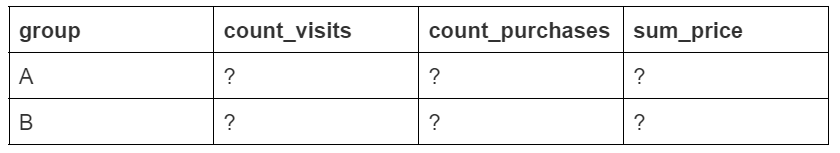
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

Чему на этот раз равно количество посещений сайта в группах А и B?


In [12]:
group_clear_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
group_clear_data.head()

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество пользователей, учавствовавших в А/В-тестировании в разных группах, соответствует на 99,94 %. Такие выборки можно считать *сбалансированными*.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [13]:
group_clear_data['conversion']=group_clear_data['count_purchases']/group_clear_data['count_visits']*100
group_clear_data['mean_check']=group_clear_data['sum_price']/group_clear_data['count_purchases']

display(group_clear_data)

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

> По полученным данным видно, что средняя стоимость тура и общаяс стоимость всех покупок в группе В выше, чем в в группе А, но показатель конверии наоборот, в группе А выше, чем в группе В. Скорее всего, в группе А покупалии более дешёвые туры. Проверим это.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [14]:
pivot = updated_data[updated_data['price']>0].pivot_table(
    values='purchase',
    columns='group',
    index='price',
    aggfunc='count'
)

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

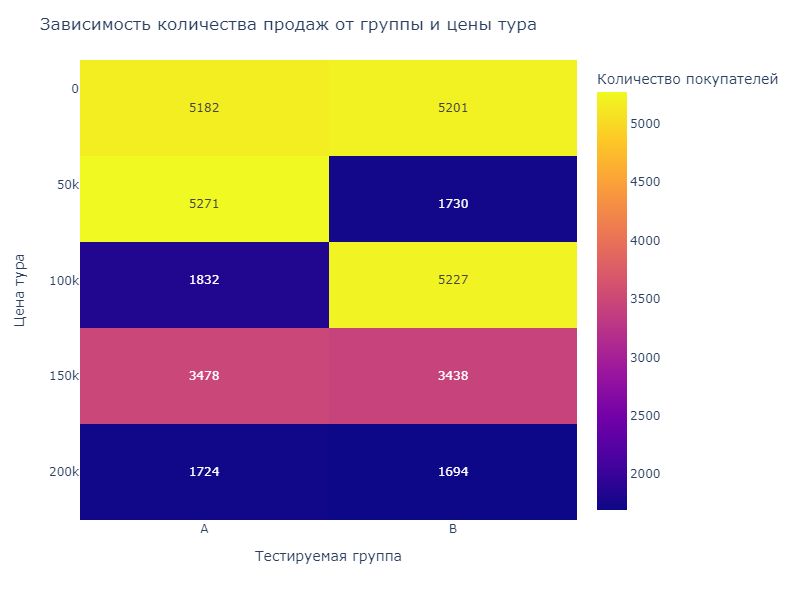

In [15]:
fig = px.imshow(
    pivot,
    width=800,
    height=600,
    text_auto=True
)
fig.update_layout(
    coloraxis_colorbar=dict(title="Количество покупателей"),
    yaxis_title_text='Цена тура',
    xaxis_title_text='Тестируемая группа',
    title='Зависимость количества продаж от группы и цены тура',
)

fig.show('png')


> Как мы и предполагали, в группе А чаще покупали тьуры до 100 тыс рублей. В группе В чаще выбриали туры стоимостью от 50 до 100 тысяч рублей. За счёт этого общая стоимость купленных туров и средняя стоимость тура в группе В выше.  

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [16]:
daily_data = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

# вычисляем кумулятивную конверсию
daily_data['conversion'] = daily_data['count_purchases']/daily_data['count_visits'] * 100
# вычисляем кумулятивный средний чек
daily_data['mean_check'] = daily_data['sum_price']/daily_data['count_purchases']

display(daily_data.head())

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

In [17]:
# вычисляем кумулятивную сумму количество посещений страницы
daily_data['cum_count_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
# вычисляем кумулятивную сумму количества совершённых покупок
daily_data['cum_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
# вычисляем кумулятивную сумму совершённых покупок
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_purchases']/daily_data['cum_count_visits'] * 100
# вычисляем кумулятивный средний чек
daily_data['cum_mean_check'] = daily_data['cum_sum_price']/daily_data['cum_purchases']


* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [18]:
mask = daily_data.date=='2021-01-20'
mask1 = daily_data.group=='B'
display (f'Кумулятивная конверсия в группе B на 20 января 2021 года = {round(daily_data[mask&mask1].cum_conversion.iloc[0],2)}')

mask = daily_data.date=='2021-01-12'
mask1 = daily_data.group=='A'
display (f'Кумулятивный средний чек в группе A на 12 января 2021 года = {round(daily_data[mask&mask1].cum_mean_check.iloc[0])}')


'Кумулятивная конверсия в группе B на 20 января 2021 года = 11.9'

'Кумулятивный средний чек в группе A на 12 января 2021 года = 81492'

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

In [19]:
fig = px.line(daily_data, x="date", 
              y="cum_conversion", 
              color='group',  
              title='График конверсии по дням',
              labels=dict(group='Тестируемая группа')
              )
fig.update_layout(
                yaxis_title_text='Кумулятивная конверсия',
                xaxis_title_text='Дата'
)
fig.show()

In [20]:
fig = px.line(daily_data, x="date", 
              y="cum_mean_check",
              color='group',  
              title='График конверсии по дням',
              labels=dict(group='Тестируемая группа')
              )
fig.update_layout(
                yaxis_title_text='Кумулятивная конверсия',
                xaxis_title_text='Дата'
)
fig.show()

> Метрики стабилизировались и можно проводить оценку эффективности внесённых изменений. 

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [21]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=group_clear_data['count_purchases'], #число "успехов"
    nobs=group_clear_data['count_visits'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


> На основании проведённого анализа статистической разницы между группами А и В нет. 

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [22]:
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [23]:
#Для удобства создадим отдельные таблицы для каждой из групп пользователей:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

#создадим функцию рассчёта доверительного интервала
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

#
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [41]:
#создадим функцию для рассчёта разницы конверсий

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

#рассчитаем разности конверсий 
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

0.050000000000000044 -0.001416316745737195
1.959963984540054 1.449301828741899e-06
Доверительный интервал для разности конверсий: (-0.38, 0.09)


> Доверительные интервалы частично перекрывают друг друга, а значит оба варианта А и В равнозначны по метрике конверсии. Статистической разницы между ними нет.  


## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [25]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости

# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data[daily_data['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(daily_data[daily_data['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [26]:
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05 # уровень значимости
print("*** Результаты независимого T-теста ***")
test_results = ttest_ind(daily_data[daily_data['group'] == 'A']['mean_check'],
                         daily_data[daily_data['group'] == 'B']['mean_check'],
                         alternative='less')

p = round(test_results[1],2)
if p>alpha:
    print(f"{p} > {alpha}. \nМы не можем отвергнуть нулевую гипотезу. {H0}")
else:
    print(f"{p} <= {alpha}. \nМы отвергаем нулевую гипотезу. {H1}")

*** Результаты независимого T-теста ***
0.0 <= 0.05. 
Мы отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше, чем в группе B


> Так как распределения в обоих группах нормальные, мы применили Т-тест для оценки ежедневного среднего чека в группах А и В. По данному параметру видно, что средний чек в группе А меньше, чем в группе В.  

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [27]:
def mean_chek_conf_interval(n, x_mean, x_std, gamma=0.95):   
    k = n-1
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound), round(upper_bound)

mean_chek_conf_interval_a = mean_chek_conf_interval(
n=daily_data[daily_data['group'] == 'A']['count_visits'].count(), # размер выборки
x_mean=daily_data[daily_data['group'] == 'A']['mean_check'].mean(), # выборочная пропорция
x_std =daily_data[daily_data['group'] == 'A']['mean_check'].std() 
)

mean_chek_conf_interval_b = mean_chek_conf_interval(
n=daily_data[daily_data['group'] == 'B']['count_visits'].count(), # размер выборки
x_mean=daily_data[daily_data['group'] == 'B']['mean_check'].mean(), # выборочная пропорция
x_std =daily_data[daily_data['group'] == 'B']['mean_check'].std() 
)

print('Доверительный интервал для среднего чека группы А: {}'.format(mean_chek_conf_interval_a))
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_chek_conf_interval_b))


Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


> Интервалы не пересекаются, это значит, что при оценке среднего чека вариант В более эффектичнее, чем вариант А.

## **Сделайте общий вывод по результатам A/B-теста**

В результате проведённого тестирования мы определили, что существенной разницы между посадочными страницами в разрезе конверсии нет, но средний чек увеличился в группе, которая тестировала новую посадочную страницу. 